In [83]:
import pandas as pd
import os
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

In [84]:
# load in correct answers
df_ans = pd.read_json("./datasets/data_mc.json", orient='records', lines=True)

In [85]:
# load in model predictions
df_dict_full = defaultdict(pd.DataFrame)

for file in os.listdir("results/eval3/"):
    if file.endswith(".json"):
        df = pd.read_json(os.path.join("./results/eval3/", file), orient='index') # transpose the dataframe
        df_dict_full[file.strip(".json")] = df

In [86]:
# normalize each row to probabilities for even comparison
# def softmax(x):
#     exp_x = np.exp(x - np.max(x))
#     return exp_x / np.sum(exp_x)

# for x, df in df_dict_full.items():
#     # in place softmax normalization on each row
#     df_dict_full[x] = df.apply(softmax, axis=1).fillna(0)
    
# use df_dict as subset of df_dict_full, excluding vanilla_t0.9 and dola_static24_t1.0, as well as any file that has top in it
df_dict = {k: v for k, v in df_dict_full.items() if 'top' not in k and 'vanilla_t0.9' not in k and 'dola_static24_t1.0' not in k}

In [87]:
# build dataframe of target: for each prompt in df_ans (each row), the probability of the correct answer (df_ans['answer'])
df_target_prob = pd.DataFrame()
df_target_penalty = pd.DataFrame()
df_target_rank = pd.DataFrame()

for i, row in df_ans.iterrows():
    # get the probability of the correct answer for each decoding strategy
    for x, df in df_dict.items():
        df_target_prob.loc[i, x] = df.loc[i, row['Answer']]

        # mask of incorrect answers
        df_target_penalty.loc[i, x] = (df.loc[i, :].idxmax() == row['Answer'])
        df_target_rank.loc[i, x] = df.loc[i, :].rank(method='min', ascending=False)[row['Answer']]


# target is one of the following: 
# 1) Decoding strategy that maximizes probability of correct answer 
theta = 0.0
y_prob = (df_target_prob - theta * df_target_penalty).idxmax(axis=1)
# 2) Decoding strategy that maximize probability of correct answer with penalty for incorrect answers
theta = 0.1
y_prob_penalty = (df_target_prob - theta * df_target_penalty).idxmax(axis=1)

# 3) Rank of correct answer, default to dola_all_t1.0
df_copy = df_target_rank.copy()
df_copy['dola_all_t1.0'] -= 1e-10
y_rank = df_copy.idxmin(axis=1) # min = better

In [88]:
df_dict.keys()

dict_keys(['dola_s8_t1.0', 'dola_s0_t1.0', 'dola_s16_t1.0', 'dola_s24_t1.0', 'vanilla', 'dola_all_t1.0'])

In [89]:
# load in prompt data
df_prompt = np.load("./datasets/embed_e5-large-v2.npy")
print(df_prompt.shape)

(1570, 1024)


In [90]:
from sklearn.model_selection import train_test_split

# split indices into train and test
train_idx, test_idx = train_test_split(np.arange(len(df_ans)), test_size=0.3, random_state=42)

# get training data
df_train = pd.concat([pd.DataFrame(df_prompt, columns=[f"embed_{i}" for i in range(df_prompt.shape[1])]), df_ans['Type'].astype('category')], axis=1)
y_bin = y_prob_penalty.apply(lambda x: 1 if 'dola' not in x else 0)

# y_target = y_prob_penalty.astype('category')
y_target = y_rank.astype('category')
# dec_dict = {
#     'vanilla_t1.0': 0,
#     'dola_static0_t1.0': 1,
#     'dola_static8_t1.0': 2,
#     'dola_static16_t1.0': 3,
#     'dola_static24_t1.0': 4,
#     'dola_all_t1.0': 5,
# }

dec_dict = {k: i for i, k in enumerate(y_target.unique().sort_values())}
dec_dict_rev = {v: k for k, v in dec_dict.items()}
y_target = y_target.map(dec_dict)

X_train = df_train.iloc[train_idx]
y_train = y_target.iloc[train_idx]
df_ans_train = df_ans.iloc[train_idx]

# get test data
X_test = df_train.iloc[test_idx]
y_test = y_target.iloc[test_idx]
df_ans_test = df_ans.iloc[test_idx]

In [91]:
from sklearn.model_selection import GridSearchCV
from tabpfn import TabPFNClassifier
# from sklearn.linear_model import LogisticRegression

# # train model
# grid = GridSearchCV(
#     estimator=XGBClassifier(enable_categorical=True),
#     param_grid={
#         'n_estimators': [100, 200, 300],
#         # 'learning_rate': [0.01, 0.05, 0.1],
#         'max_depth': [3, 4, 5]
#     },
#     cv=3,
#     n_jobs=-1
# )
# grid.fit(X_train, y_train)
# model = grid.best_estimator_

model = TabPFNClassifier()
# model = LogisticRegression()
model.fit(X_train, y_train)

,n_estimators,8
,categorical_features_indices,None
,softmax_temperature,0.9
,balance_probabilities,False
,average_before_softmax,False
,model_path,'auto'
,device,'auto'
,ignore_pretraining_limits,False
,inference_precision,'auto'
,fit_mode,'fit_preprocessors'
,memory_saving_mode,'auto'


In [92]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# evaluate model just in terms of accuracy/roc in predicting best decoding strategy
# y_pred = model.predict(X_test)
# y_pred_proba = model.predict_proba(X_test)

y_pred_proba = model.predict_proba(X_test)
y_pred = y_pred_proba.argmax(axis=1)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba, multi_class='ovr', labels=np.arange(len(df_dict)), average=None)}")

Accuracy: 0.49256900212314225
              precision    recall  f1-score   support

           0       0.50      0.91      0.65       222
           2       0.00      0.00      0.00        20
           3       0.63      0.18      0.28        66
           4       0.00      0.00      0.00        22
           5       0.37      0.12      0.18       141

    accuracy                           0.49       471
   macro avg       0.30      0.24      0.22       471
weighted avg       0.43      0.49      0.40       471

ROC AUC: [0.57199971        nan 0.44800443 0.69614665 0.60862523 0.58689018]


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

In [94]:
#roc ovr per class:
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', labels=np.arange(len(df_dict)), average=None)
print(roc_auc)
for i, r in enumerate(roc_auc):
    print(f"ROC AUC for class {dec_dict_rev[i]}: {r}")

[0.57199971        nan 0.44800443 0.69614665 0.60862523 0.58689018]
ROC AUC for class dola_all_t1.0: 0.5719997105539274
ROC AUC for class dola_s0_t1.0: nan
ROC AUC for class dola_s16_t1.0: 0.44800443458980044
ROC AUC for class dola_s24_t1.0: 0.6961466517022071
ROC AUC for class dola_s8_t1.0: 0.6086252277789026
ROC AUC for class vanilla: 0.58689017837954


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


In [95]:
# evaluate model on prompts (how much better is the dynamic strategy than the static strategy?)
acc_on_prompts = {t: {} for t in df_ans_test['Type'].unique()}

# first, get accuracy of plain decoding strategies on prompts
for x, df in df_dict_full.items():
    print("accuracy of", x, ":")
    y_pred_dec = df.iloc[test_idx, :].idxmax(axis=1)
    print(f" - Total:{accuracy_score(df_ans_test['Answer'], y_pred_dec)}")
    print(" - By question type:")
    for t in df_ans_test['Type'].unique():
        acc_on_t = accuracy_score(df_ans_test[df_ans_test['Type'] == t]['Answer'], y_pred_dec[df_ans_test['Type'] == t])
        acc_on_prompts[t][x] = acc_on_t
        print(f"   - {t}: {acc_on_t}")

print("--------------------------------")
# then, get accuracy of model on prompts
y_pred_model = []
for i, (idx, row) in enumerate(df_ans_test.iterrows()):
    # randomly choose a dola decoding strategy
    dec = dec_dict_rev[y_pred[i]]
    y_pred_model.append(df_dict[dec].iloc[idx, :].idxmax(axis=0))

print(f"Accuracy of model: {accuracy_score(df_ans_test['Answer'], pd.Series(y_pred_model))}")
print(" - By question type:")
for t in df_ans_test['Type'].unique():
    acc_on_t = accuracy_score(df_ans_test[df_ans_test['Type'] == t]['Answer'], np.array(y_pred_model)[df_ans_test['Type'] == t])
    acc_on_prompts[t]['model'] = acc_on_t
    print(f"   - {t}: {acc_on_t}")

accuracy of dola_s8_t1.0 :
 - Total:0.34394904458598724
 - By question type:
   - HellaSwag: 0.288
   - TruthfulQA: 0.3465346534653465
   - college_computer_science: 0.43333333333333335
   - clinical_knowledge: 0.2638888888888889
   - international_law: 0.5714285714285714
accuracy of dola_s0_t1.0 :
 - Total:0.32908704883227174
 - By question type:
   - HellaSwag: 0.28
   - TruthfulQA: 0.33663366336633666
   - college_computer_science: 0.4
   - clinical_knowledge: 0.2361111111111111
   - international_law: 0.5476190476190477
accuracy of top_p0.9_t1.0 :
 - Total:0.28874734607218683
 - By question type:
   - HellaSwag: 0.36
   - TruthfulQA: 0.24257425742574257
   - college_computer_science: 0.13333333333333333
   - clinical_knowledge: 0.3472222222222222
   - international_law: 0.30952380952380953
accuracy of dola_s16_t1.0 :
 - Total:0.3375796178343949
 - By question type:
   - HellaSwag: 0.272
   - TruthfulQA: 0.33663366336633666
   - college_computer_science: 0.4
   - clinical_knowledge:

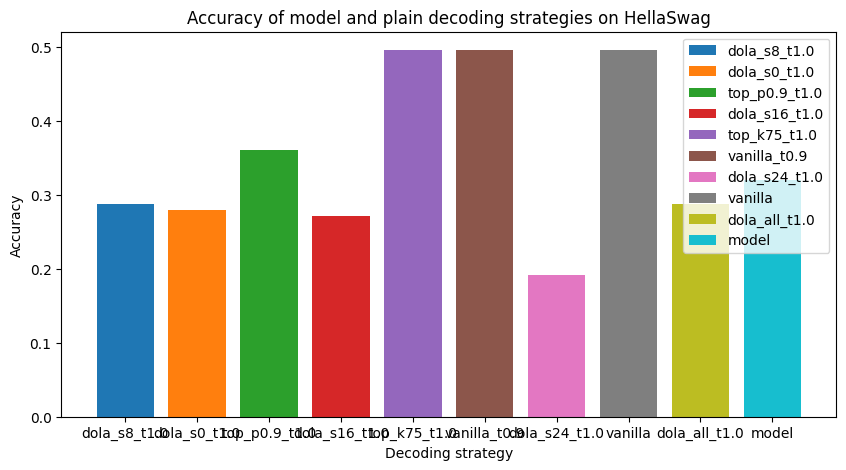

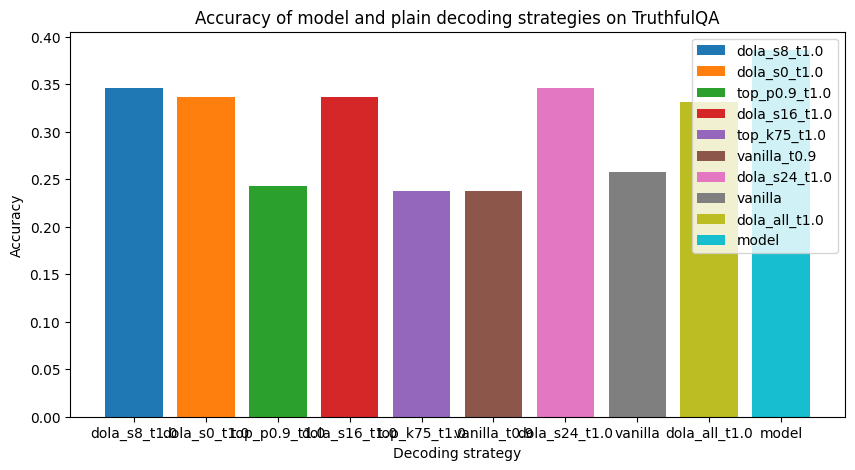

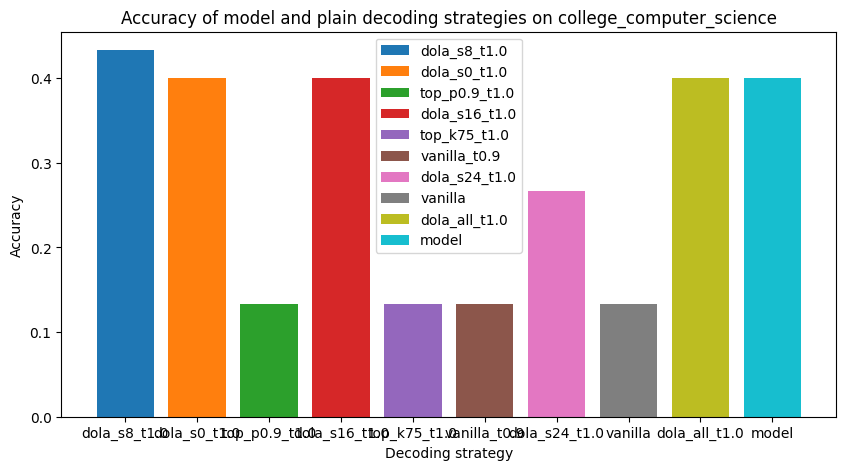

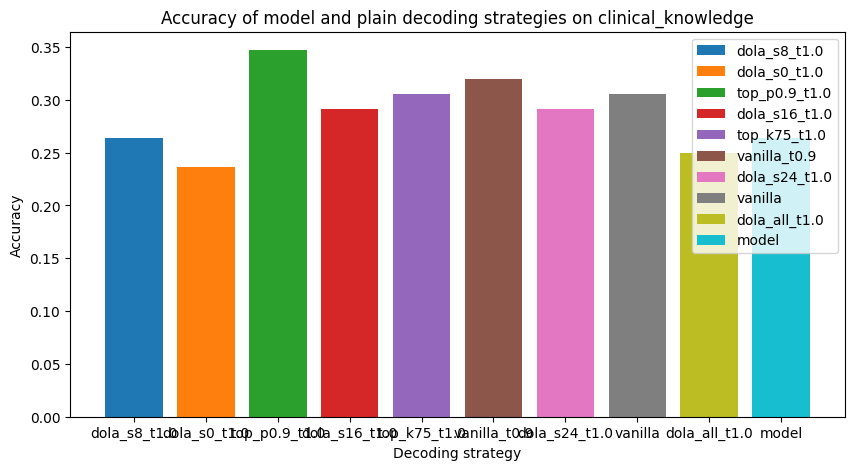

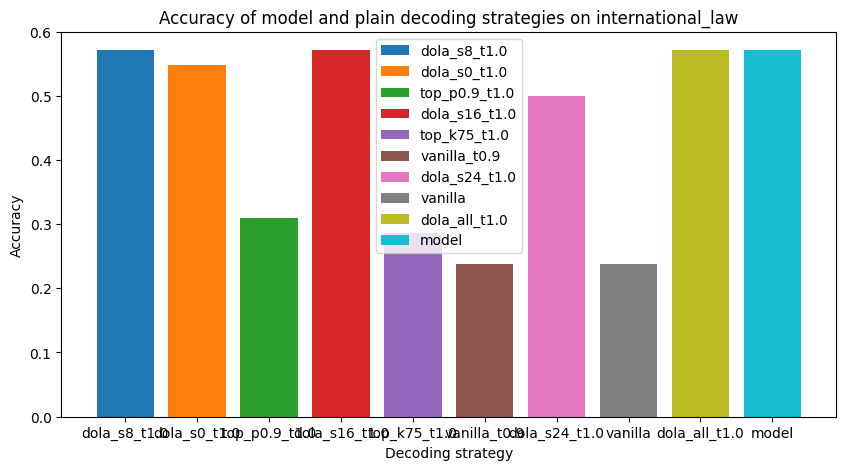

In [96]:
# for each type, plot the accuracy of the model and the plain decoding strategies
# add title, xlabel, ylabel, as well as a legend, and way to differentiate model and plain decoding strategies
# we need 5 plots, one for each question type
for t in df_ans_test['Type'].unique(): 
    plt.figure(figsize=(10, 5))
    xs = list(acc_on_prompts[t].keys())
    plt.bar(xs, [acc_on_prompts[t][x] for x in acc_on_prompts[t].keys()], label=xs, color=plt.cm.tab10.colors)
    plt.title(f"Accuracy of model and plain decoding strategies on {t}")
    plt.xlabel("Decoding strategy")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


In [52]:
pd.DataFrame([dec_dict_rev[y_pred[i]] for i in range(len(y_pred))]).value_counts()

0            
dola_all_t1.0    348
vanilla_t0.9     116
dola_s24_t1.0      7
Name: count, dtype: int64

In [23]:
df_ans['Type'].value_counts()

Type
TruthfulQA                  684
clinical_knowledge          265
international_law           121
college_computer_science    100
Name: count, dtype: int64